#### This notebook shows how to apply multi-channel data standardization to MRI data.

In [1]:
# Testing if integration works

In [2]:
%matplotlib inline

import h5py
import numpy as np
from matplotlib import pyplot as plt
import bart

from data import transforms as T
from common.utils import tensor_to_complex_np

We start by loading a file from the knee multi-coil dataset and extracting s k-space slice from the volume, as described in the notebook 'fastMRI_tutorial'.

In [3]:
file_name = 'dataset/knee/file1001465.h5'
hf = h5py.File(file_name)

In [4]:
volume_kspace = hf['kspace'][()]
slice_kspace = volume_kspace[20] # Choosing the 20-th slice of this volume
print(slice_kspace.dtype)
print(slice_kspace.shape)

complex64
(15, 640, 322)


Let's define some helper functions for plotting the coil images.

In [5]:
def show_coils(data, slice_nums, cmap=None):
    fig = plt.figure()
    for i, num in enumerate(slice_nums):
        plt.subplot(1, len(slice_nums), i + 1)
        plt.imshow(data[num], cmap=cmap)

In [6]:
def kspace_to_image(slice_kspace):
    """
    Transfroms kspace data to real-valued image.
    Args:
        slice_kspace (numpy.array): Multi-coil input k-space of shape (num_coils, rows, cols) 
    Returns:
        image: (numpy.array): Multi-channel image of shape (num_coils, rows, cols)
    """
    slice_kspace2 = T.to_tensor(slice_kspace)      # Convert from numpy array to pytorch tensor
    slice_image = T.ifft2(slice_kspace2)           # Apply Inverse Fourier Transform to get the complex image
    slice_image_abs = T.complex_abs(slice_image)   # Compute absolute value to get a real image
    return slice_image_abs

First, we plot the absolute values of the Inverse Fourier Transform of some multi-coil k-space data.

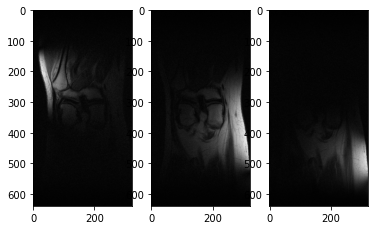

In [7]:
show_coils(kspace_to_image(slice_kspace), [0, 5, 10], cmap='gray')

Then, we estimate the sensitivity maps using ESPIRiT method provided by BART toolbox.

In [8]:
def estimate_sensitivity_maps(kspace):
    kspace_perm = np.moveaxis(kspace, 0,2)
    kspace_perm = np.expand_dims(kspace_perm, axis=0)    
    # Estimate sensitivity maps with ESPIRiT method
    S = bart.bart(1, "ecalib -d0 -m1", kspace_perm)
    S = np.moveaxis(S.squeeze(), 2, 0)
    return S

In [9]:
def show_ensitivity_maps(S, nc=15):
    fig = plt.figure()
    for i in range(nc):
        plt.subplot(1, nc, i+1)
        plt.imshow(abs(S[i,:,:]), cmap='gray')
        plt.title('S {}'.format(i+1))

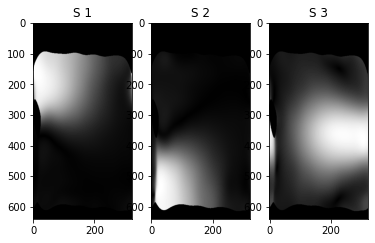

In [10]:
S = estimate_sensitivity_maps(slice_kspace)
show_ensitivity_maps(S, 3)

The last step is to combine the multi-coil images based on the estimated coil sensitivity maps.

The combined image is computed as follows $$M^{comb} = \sum_{i} {conj(S_i)*M_i}.$$
The residual images correspond to $$M_i^{res} = M_i - S_i * M^{comb},$$
where $S_i$ is the estimated sensitivity map corresponding to coil $i$.

In [11]:
def apply_multi_channel_data_standardization(kspace, S):
    """
    Applies Multi-channel standardization to multi-coil data using sensitivity maps estimated with ESPIRiT method,
    as described by AIRS Medical team.
    Args:
        kspace  (numpy.array): slice kspace of shape (num_coils, rows, cols)
        S       (numpy.array): Estimated sensitivity maps given by ESPIRiT
    Returns:
        numpy.array: Standardized data of shape (num_coils+1, rows, cols)
    """
    # First get the image
    kspace2 = T.to_tensor(kspace)      # Convert from numpy array to pytorch tensor
    image2 = T.ifft2(kspace2)           # Apply Inverse Fourier Transform to get the complex image
    image = tensor_to_complex_np(image2)
    # use S to combine the multi-channel data using a conjugate sum
    M_comb = np.sum(np.multiply(np.conj(S), image), axis=0)
    # compute residual image to consider sensitivity estimation errors or artifacts
    M_res = image - np.multiply(S, M_comb)
    M_comb = np.expand_dims(M_comb, axis=0)
    M_out = np.concatenate((M_comb, M_res))
    return M_out

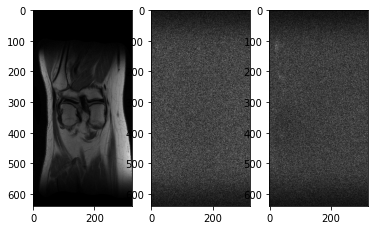

In [12]:
standardized_image = apply_multi_channel_data_standardization(slice_kspace, S)
show_coils(T.complex_abs(T.to_tensor(standardized_image)), [0, 5, 10], cmap='gray')

Note that when training a model, we would perform these steps on the subsampled data instead of the fully-sampled data used in this notebook.